In [118]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import copy
from tqdm import tqdm
import time
import scipy

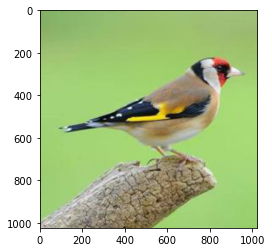

(1024, 1024, 3)


In [19]:
""" 
    1.K-Means Clustering
       a) K = 2, 4, 8, 16, 32 with vector=(R, G, B)
       b) same as above but vector=(R, G, B, x, y)
       c) compare (a) and (b)
"""
img = cv2.imread("./bird.jpg")

# displaying image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print(img.shape)

In [20]:
# sklearn: 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://realpython.com/k-means-clustering-python/
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

def getKMeansImg(scaled_features, img, clusterNum=2):
    kmeans = KMeans(
        init="random",
        n_clusters=clusterNum,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    
    kmeans.fit(scaled_features)
    print(kmeans.inertia_)
    centers = kmeans.cluster_centers_
    print(centers)
    labels = kmeans.labels_
    #print(labels[:5])
    centers = centers.astype(np.uint8)
    print(centers)
    
    coloredImg = copy.deepcopy(img)
    for i in range(rows):
        for j in range(cols):
            coloredImg[i][j] = centers[ labels[i*rows + j] ][:3]
    
    return coloredImg

def generateData(img):
    scaled_features = []
    rows, cols, depth = img.shape
    for i in range(rows):
        for j in range(cols):
            scaled_features.append(img[i][j])
            
    return scaled_features

def generateDataWithXY(img):
    scaled_features = []
    rows, cols, depth = img.shape
    for i in range(rows):
        for j in range(cols):
            scaled_features.append(np.concatenate((img[i][j], [i, j]), axis=0))
            
    return scaled_features

In [139]:
# K-means and K-medians
# modify from following link
# https://medium.com/@pasdan/k-clustering-means-medians-via-python-2a5f251582ee

def euclidean_distance(a, b):
    return np.sum(np.square(a - b))
    #return np.sqrt(np.sum(np.square(a - b)))
    
def assign_labels(instance, clusters):
    each_distance = [ 
        euclidean_distance(instance, oneCluster) for oneCluster in clusters 
    ]
    label = np.argmin(each_distance) # min index
    return label, each_distance[label]

def clusterL2(scaled_features, clusters):
    #https://stackoverflow.com/questions/6430091/efficient-distance-calculation-between-n-points-and-a-reference-in-numpy-scipy
    """
    tempArray = None
    for oneCluster in clusters:
        distance = np.square(scaled_features - oneCluster)
        #print(distance)
        distance = np.sqrt(np.sum(distance, axis=1))
        #print(distance)
        distance = np.expand_dims(distance, axis=0)
        if tempArray is None:
            tempArray = distance
        else:
            tempArray = np.concatenate((tempArray, distance), axis = 0)
    #print(tempArray)
    return np.argmin(tempArray, axis=0)
    """
    # 20% faster (30s -> 23s)
    tempArray = scipy.spatial.distance.cdist(scaled_features, clusters)
    return np.argmin(tempArray, axis=1)

def updateCentroid(targetList):
    #return np.mean(targetList, axis=0)
    return np.median(targetList, axis=0)

def myKMeans(scaled_features, img, clusterNum=2):
    scaled_features = np.array(scaled_features).astype(np.float64)
    random_init = 10
    iterations = 300
    np.random.seed(42)
    tolarance = 1e-4
    uniqueData = np.unique(scaled_features, axis=0)
    
    numSamples, numVector = scaled_features.shape
    
    
    ans = None
    ansInertia = None
    tempAns = None
    tempInertia = 0
    prevAns = np.zeros((clusterNum, numVector))
    for i in range(random_init):
        
        init_indices = np.random.randint(0, len(uniqueData), clusterNum)
        tempAns = uniqueData[init_indices]
        #print(tempAns)
        for j in tqdm(range(iterations)):
            tempInertia = 0
            # use matrix
            labels = clusterL2(scaled_features, tempAns)
            #print(labels)
            #clusterData = [
            #    scaled_features[np.where(labels == k)[0]] for k in range(clusterNum)
            #]
            #print("==clusterdata==")
            #print(clusterData)
            for k in range(clusterNum):
                clusterData = scaled_features[np.where(labels == k)[0]]
                tempAns[k] = updateCentroid(clusterData)
                tempInertia += np.sum(np.square(clusterData - tempAns[k]))
            #print(tempAns)
            if euclidean_distance(prevAns, tempAns) <= tolarance:
                break
            
        print("tempInertia %d" % tempInertia)
        if ansInertia is None or tempInertia < ansInertia:
            ansInertia = tempInertia
            ans = copy.deepcopy(tempAns)
    
    return clusterL2(scaled_features, ans), ans






In [123]:
a = np.array([[1, 2, 3], [1, 1, 1], [2, 2, 2]])
b = np.array([0, 1, 0])
print(a - b)
print(np.square(a - b))
print(np.expand_dims(np.sum(a, axis=1), axis = 1) )

c = np.array([[1, 2, 2], [1, 1, 0]])
print("=====")
print(clusterL2(a, c))
tempArray = scipy.spatial.distance.cdist(a, c)
print(np.argmin(tempArray, axis=1))
d = np.array([1, 2, 3, 4, 5, 1])
print(np.where(d == 1)[0])
e = np.array([1, 4])
print(d[e])

[[1 1 3]
 [1 0 1]
 [2 1 2]]
[[1 1 9]
 [1 0 1]
 [4 1 4]]
[[6]
 [3]
 [6]]
=====
[0 1 0]
[0 1 0]
[0 5]
[2 5]


In [122]:
scaled_features = generateData(img)

  1%|▌                                                                                 | 2/300 [00:00<00:26, 11.05it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:26, 11.11it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:26, 11.23it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:26, 11.05it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:27, 10.99it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:26, 11.05it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:26, 11.30it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:26, 11.17it/s]

tempInertia 1678459475


  1%|▌                                                                                 | 2/300 [00:00<00:27, 10.99it/s]

tempInertia 1678459475


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.43it/s]


tempInertia 1678459475
[[162. 207. 116.]
 [135. 120.  88.]]


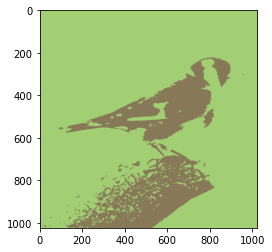

(1024, 1024, 3)


In [140]:
labels, centers = myKMeans(scaled_features=scaled_features, img=img, clusterNum=2)
rows, cols, depth = img.shape
coloredImg = copy.deepcopy(img)
print(centers)
centers = centers.astype(np.uint8)
for i in range(rows):
    for j in range(cols):
        coloredImg[i][j] = centers[ labels[i*rows + j] ][:3]
plt.imshow(coloredImg)
plt.show()
print(coloredImg.shape)

  0%|▎                                                                                 | 1/300 [00:00<00:32,  9.26it/s]

tempInertia 700105841


  0%|▎                                                                                 | 1/300 [00:00<00:32,  9.09it/s]

tempInertia 697606739


  0%|▎                                                                                 | 1/300 [00:00<00:32,  9.17it/s]

tempInertia 912160619


  0%|▎                                                                                 | 1/300 [00:00<00:33,  9.01it/s]

tempInertia 700105841


  0%|▎                                                                                 | 1/300 [00:00<00:31,  9.52it/s]

tempInertia 700105841


  0%|▎                                                                                 | 1/300 [00:00<00:32,  9.26it/s]

tempInertia 698287477


  0%|▎                                                                                 | 1/300 [00:00<00:32,  9.26it/s]

tempInertia 697606739


  1%|▌                                                                                 | 2/300 [00:00<00:31,  9.58it/s]

tempInertia 697606739


  0%|▎                                                                                 | 1/300 [00:00<00:30,  9.80it/s]

tempInertia 700105841


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:32<00:00,  9.33it/s]


tempInertia 697606739
[[180. 179. 158.]
 [145. 130.  99.]
 [ 50.  54.  45.]
 [161. 209. 116.]]


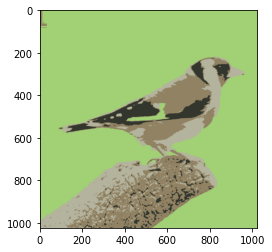

  0%|▎                                                                                 | 1/300 [00:00<00:43,  6.85it/s]

tempInertia 383819170


  0%|▎                                                                                 | 1/300 [00:00<00:43,  6.85it/s]

tempInertia 342569706


  0%|▎                                                                                 | 1/300 [00:00<00:43,  6.89it/s]

tempInertia 380177015


  0%|▎                                                                                 | 1/300 [00:00<00:42,  7.09it/s]

tempInertia 341729624


  0%|▎                                                                                 | 1/300 [00:00<00:43,  6.94it/s]

tempInertia 409254241


  0%|▎                                                                                 | 1/300 [00:00<00:43,  6.94it/s]

tempInertia 343035659


  0%|▎                                                                                 | 1/300 [00:00<00:41,  7.20it/s]

tempInertia 380739061


  0%|▎                                                                                 | 1/300 [00:00<00:43,  6.90it/s]

tempInertia 384909378


  0%|▎                                                                                 | 1/300 [00:00<00:43,  6.90it/s]

tempInertia 341729624


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.11it/s]


tempInertia 331824048
[[163. 212. 118.]
 [227. 201.  32.]
 [190. 192. 176.]
 [166. 158. 135.]
 [115. 101.  68.]
 [ 35.  40.  38.]
 [157. 193. 110.]
 [147. 132. 102.]]


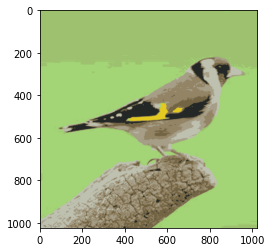

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 198211489


  0%|▎                                                                                 | 1/300 [00:00<01:03,  4.72it/s]

tempInertia 203119799


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 284428336


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 190113391


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 194691821


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 196551477


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 199680225


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 286342376


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 197183347


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:03<00:00,  4.69it/s]


tempInertia 191482689
[[163. 155. 133.]
 [174. 172. 152.]
 [ 22.  25.  25.]
 [ 42.  52.  64.]
 [231. 208.  33.]
 [213. 212. 206.]
 [165. 213. 118.]
 [156. 192. 110.]
 [143. 129. 101.]
 [111.  98.  66.]
 [159. 207. 113.]
 [128. 114.  84.]
 [158. 142. 113.]
 [ 90.  75.  44.]
 [188. 190. 175.]
 [156. 121.  68.]]


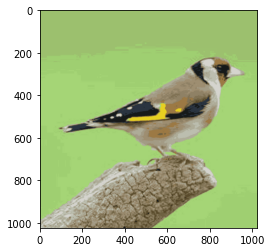

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 112628294


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 112558631


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 109243517


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 121393055


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 119860869


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 111078545


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 123415256


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 113407645


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

tempInertia 106124478


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:44<00:00,  2.87it/s]


tempInertia 113274900
[[122. 107.  72.]
 [136. 120.  87.]
 [159. 155. 141.]
 [197. 198. 189.]
 [164. 143.  93.]
 [219. 218. 215.]
 [159. 208. 113.]
 [163. 212. 121.]
 [131. 124. 109.]
 [236. 213.  35.]
 [186. 148.  30.]
 [110. 106.  91.]
 [106.  91.  58.]
 [183. 182. 171.]
 [148. 131. 101.]
 [167. 153. 122.]
 [195. 182. 148.]
 [147. 115.  64.]
 [ 66.  76.  84.]
 [200.  76.  68.]
 [143. 185. 108.]
 [ 27.  34.  39.]
 [158. 194. 111.]
 [158. 141. 112.]
 [146. 140. 126.]
 [179. 166. 133.]
 [173. 205. 139.]
 [ 85.  68.  37.]
 [ 18.  19.  15.]
 [166. 217. 117.]
 [170. 169. 156.]
 [ 41.  52.  65.]]


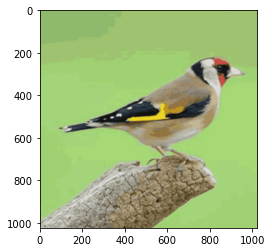

In [141]:
labels, centers = myKMeans(scaled_features=scaled_features, img=img, clusterNum=4)
coloredImg = copy.deepcopy(img)
print(centers)
centers = centers.astype(np.uint8)
for i in range(rows):
    for j in range(cols):
        coloredImg[i][j] = centers[ labels[i*rows + j] ][:3]
plt.imshow(coloredImg)
plt.show()

labels, centers = myKMeans(scaled_features=scaled_features, img=img, clusterNum=8)
coloredImg = copy.deepcopy(img)
print(centers)
centers = centers.astype(np.uint8)
for i in range(rows):
    for j in range(cols):
        coloredImg[i][j] = centers[ labels[i*rows + j] ][:3]D
plt.imshow(coloredImg)
plt.show()

labels, centers = myKMeans(scaled_features=scaled_features, img=img, clusterNum=16)
coloredImg = copy.deepcopy(img)
print(centers)
centers = centers.astype(np.uint8)
for i in range(rows):
    for j in range(cols):
        coloredImg[i][j] = centers[ labels[i*rows + j] ][:3]
plt.imshow(coloredImg)
plt.show()

labels, centers = myKMeans(scaled_features=scaled_features, img=img, clusterNum=32)
coloredImg = copy.deepcopy(img)
print(centers)
centers = centers.astype(np.uint8)
for i in range(rows):
    for j in range(cols):
        coloredImg[i][j] = centers[ labels[i*rows + j] ][:3]
plt.imshow(coloredImg)
plt.show()

1485135644.3601499
[[107.69008695  95.56129696  71.60061825]
 [163.22597756 197.72311134 120.58332123]]
[[107  95  71]
 [163 197 120]]
=== 6.31635308265686 sec ===


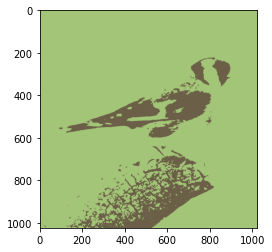

(1024, 1024, 3)


In [117]:
scaled_features = generateData(img)
start_time = time.time()
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=2)
print("=== %s sec ===" % (time.time() - start_time))
plt.imshow(coloredImg)
plt.show()
print(coloredImg.shape)

676079930.2034442
[[160.65391076 204.76147504 114.70177043]
 [183.98722794 182.76930528 165.05373761]
 [143.95082188 128.30758678  97.23666128]
 [ 58.34971514  55.15948114  46.2070495 ]]
[[160 204 114]
 [183 182 165]
 [143 128  97]
 [ 58  55  46]]


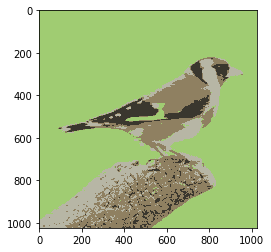

(1024, 1024, 3)


In [19]:
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=4)
plt.imshow(coloredImg)
plt.show()
print(coloredImg.shape)

324016017.74952275
[[ 38.34403865  40.51586048  41.09324866]
 [154.67881384 192.73016865 110.88501921]
 [220.37177106 190.90207665  36.29275705]
 [149.50811418 134.01702648 104.45562573]
 [163.39815155 211.85529595 117.63553089]
 [198.93887856 200.04030389 188.04909454]
 [170.70603082 165.26979999 143.62250946]
 [115.34359969  99.50735907  67.81135766]]
[[ 38  40  41]
 [154 192 110]
 [220 190  36]
 [149 134 104]
 [163 211 117]
 [198 200 188]
 [170 165 143]
 [115  99  67]]


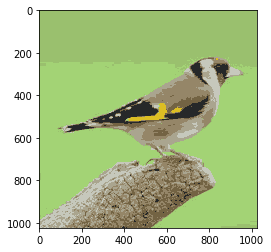

(1024, 1024, 3)


In [20]:
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=8)
plt.imshow(coloredImg)
plt.show()
print(coloredImg.shape)

204900639.45482245
[[162.66322465 214.77402631 109.83461159]
 [162.49293119 210.98694103 119.2596859 ]
 [151.48043916 136.64707109 107.77196859]
 [126.14589576 113.84712585  83.72336777]
 [ 94.51971065  82.7876626   56.87081895]
 [166.22684104 157.72100121 135.86182203]
 [158.6686822  205.27007122 111.15592986]
 [183.15662965 182.34322665 172.01651208]
 [156.93564956 192.59975767 112.14135066]
 [167.1387264  216.85091652 118.00471886]
 [ 32.39398291  36.19921735  39.40198894]
 [212.06427415 211.91295197 204.66562331]
 [180.72502325 198.15744147 143.49185299]
 [227.49067937 201.20836785  36.15782933]
 [165.16332073 112.69808942  56.1586655 ]
 [140.66339138 182.10066641 107.34251873]]
[[162 214 109]
 [162 210 119]
 [151 136 107]
 [126 113  83]
 [ 94  82  56]
 [166 157 135]
 [158 205 111]
 [183 182 172]
 [156 192 112]
 [167 216 118]
 [ 32  36  39]
 [212 211 204]
 [180 198 143]
 [227 201  36]
 [165 112  56]
 [140 182 107]]


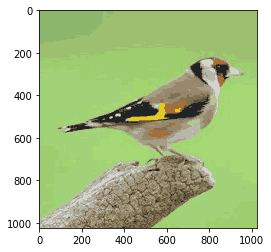

(1024, 1024, 3)


In [21]:
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=16)
plt.imshow(coloredImg)
plt.show()
print(coloredImg.shape)

120045559.72551097
[[194.61539235 173.08641851 133.78551308]
 [150.32710543 189.91262204 111.75735759]
 [141.90860315 184.01036078 108.71615171]
 [123.15171153 109.07986042  75.97969425]
 [143.316113   125.04577557  88.20798457]
 [173.15773223 172.17300618 158.91449875]
 [159.47338669 208.60483814 117.55475857]
 [ 70.35483278  81.31569276  89.76203602]
 [ 82.18909381  62.44159836  33.47404372]
 [218.50590051 217.77251271 213.88153595]
 [159.58146431 201.22864334 113.37318082]
 [174.11394436 203.50976271 141.76237624]
 [156.71021473 204.62760051 106.15529467]
 [180.92204449 109.90972605  48.19121162]
 [159.64933792 191.16483051 119.78376589]
 [156.09735867 191.67122752 109.97887276]
 [229.01176214 203.36244827  36.2269658 ]
 [105.29771505  90.30939826  57.18879239]
 [156.70367707 139.29978944 107.3639585 ]
 [155.60169811 151.26275472 137.85109434]
 [200.44044944 206.97233146 167.18946629]
 [164.31251358 213.30842858 116.27569423]
 [131.27451191 126.58231593 112.77991717]
 [158.98462219 

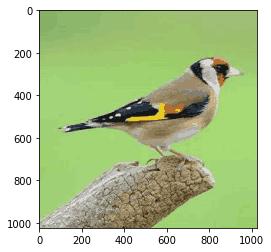

(1024, 1024, 3)


In [22]:
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=32)
plt.imshow(coloredImg)
plt.show()
print(coloredImg.shape)

118008843173.05766
[[154.51918659 186.78887678 117.14434188 508.86023737 255.00446649]
 [156.37125628 180.0449913  110.32015091 514.12913014 766.96241525]]
[[154 186 117 252 255]
 [156 180 110   2 254]]


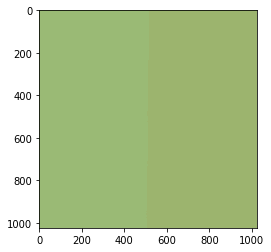

49234536161.755554
[[157.23478838 183.17930383 111.53019294 768.62159507 768.31736656]
 [151.88021165 194.04698069 111.31743531 255.03354837 255.4887975 ]
 [157.04947428 178.95743636 122.723715   767.32060293 256.12502711]
 [155.63002474 177.48896144 109.31109025 256.90907294 767.29181029]]
[[157 183 111   0   0]
 [151 194 111 255 255]
 [157 178 122 255   0]
 [155 177 109   0 255]]


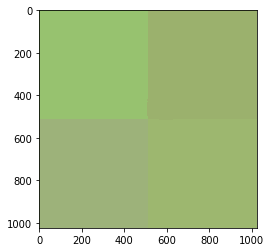

26638233202.13683
[[157.12650042 182.09073319 114.10808909 165.62197298 851.66780865]
 [164.26292354 187.31491847 134.31171055 855.53868709 171.81499365]
 [159.8846584  202.11421468 117.67327908 857.02256422 857.71530203]
 [151.98593382 194.06575061 111.71604011 166.82967079 170.73625503]
 [147.8350318  146.02042249 104.57414742 794.5202623  518.27536963]
 [160.06359219 181.63622157 110.60892802 510.61573536 807.62136532]
 [154.08125791 188.57263746 108.64721504 232.63952336 510.76706203]
 [150.57037221 192.06503524 112.23305592 514.28998831 215.88165882]]
[[157 182 114 165  83]
 [164 187 134  87 171]
 [159 202 117  89  89]
 [151 194 111 166 170]
 [147 146 104  26   6]
 [160 181 110 254  39]
 [154 188 108 232 254]
 [150 192 112   2 215]]


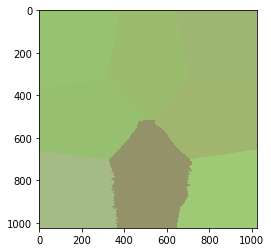

13939860821.628166
[[159.16098752 185.51670324 112.60585013 131.41767535 892.49750796]
 [158.34084832 197.42134594 110.28534437 142.6229559  636.26914633]
 [148.52323068 189.3014806  109.99669825 135.88141842 124.79013918]
 [151.74624034 144.92905492 123.71446373 876.15718372 380.98210088]
 [125.77469032 115.05359733  86.17496453 410.84505875 662.04975529]
 [162.93864021 165.21423137 113.99972053 643.97588771 602.85776391]
 [159.37235973 208.50857849 118.24837199 902.27873603 892.48858489]
 [160.09861023 207.03043321 116.46299478 671.49549305 131.91999035]
 [139.14482707 141.50360695  91.65530652 891.50767404 633.93609915]
 [167.8418903  214.54749607 119.91782225 647.2164552  880.69520548]
 [161.08741237 207.76931057 114.42587004 326.03021158 401.72017354]
 [162.8694644  210.87561904 119.58901325 402.3698938  130.57306845]
 [134.48030262 161.72510723 101.45295263 576.61869866 365.04134154]
 [168.46222853 189.36795857 143.63012028 908.14360174 128.65897093]
 [173.4185355  200.77324828 1

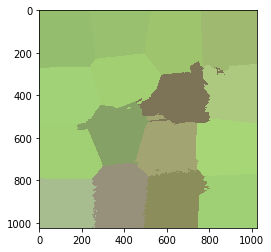

7359222937.517647
[[161.33929735 204.23476868 116.70183536 274.97116638 103.14957103]
 [162.98304491 166.43487268 135.50862096 768.70577174 450.34569908]
 [135.23922265 120.47277301  87.88189307 792.86105357 666.31288843]
 [174.99108015 199.48014194 148.60723354 793.28357966 252.72664236]
 [174.68625548 210.97011832 124.19933363 433.10995094 905.99648451]
 [156.01052409 209.21989024 114.64760871 935.61660937 931.40374525]
 [159.79817704 207.57197965 115.94176083 798.21578534  78.98832486]
 [157.60937283 196.10960882 109.69646575 109.23429301 604.29256781]
 [166.5360587  212.88928197 124.34203354 769.96949686 897.95707547]
 [142.41447409 132.99987791 113.76359807 943.44344057 326.46212075]
 [158.74672106 193.16358416 113.36854034  98.46382593 773.70160169]
 [ 64.06479644  54.09252803  52.02671244 390.83875986 757.36700102]
 [163.02155377 211.62589807 120.93726762 454.93631713 100.35405776]
 [166.68224782 175.87885603 130.52271829 286.64112695 728.75145124]
 [158.61498872 189.81581359 11

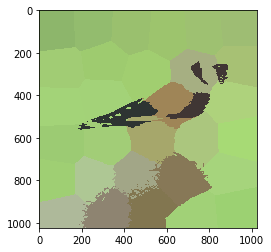

In [25]:
scaled_features = generateDataWithXY(img)
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=2)
plt.imshow(coloredImg)
plt.show()
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=4)
plt.imshow(coloredImg)
plt.show()
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=8)
plt.imshow(coloredImg)
plt.show()
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=16)
plt.imshow(coloredImg)
plt.show()
coloredImg = getKMeansImg(scaled_features=scaled_features, img=img, clusterNum=32)
plt.imshow(coloredImg)
plt.show()